In [3]:
import torch
import math

import numpy as np

In [14]:
# Testing linear variance schedules and how they behave
def linear_variance_schedule(min: float, max: float, T: int):
    betas = torch.arange(0, T) / T
    betas *= max - min
    betas += min
    return betas

def abar(t): 
    return (t*math.pi/2).cos()**2

In [15]:
# Compute variance schedule
betas = linear_variance_schedule(1e-4, 0.02, 10).to("cuda")
# Calculating the constants based on the implementation
alphas = 1 - betas
alpha_bar = torch.exp(torch.cumsum(torch.log(alphas), dim=0))
# These constants will dictate how much of the image and the noise respectively will be combined
sqrt_alphabar = torch.sqrt(alpha_bar)
sqrt_1malphabar = torch.sqrt(1 - alpha_bar)

In [16]:
print(betas)

tensor([1.0000e-04, 2.0900e-03, 4.0800e-03, 6.0700e-03, 8.0600e-03, 1.0050e-02,
        1.2040e-02, 1.4030e-02, 1.6020e-02, 1.8010e-02], device='cuda:0')


In [22]:
print(abar(torch.arange(1, 1000)))

tensor([1.9107e-15, 1.0000e+00, 1.4220e-16, 1.0000e+00, 1.1409e-13, 1.0000e+00,
        4.4038e-13, 1.0000e+00, 1.2798e-15, 1.0000e+00, 1.7300e-12, 1.0000e+00,
        4.7260e-13, 1.0000e+00, 3.5551e-15, 1.0000e+00, 1.7933e-12, 1.0000e+00,
        5.0596e-13, 1.0000e+00, 3.9634e-12, 1.0000e+00, 2.9633e-13, 1.0000e+00,
        5.4046e-13, 1.0000e+00, 4.0589e-12, 1.0000e+00, 2.7093e-13, 1.0000e+00,
        5.7609e-13, 1.0000e+00, 4.1556e-12, 1.0000e+00, 1.1009e-11, 1.0000e+00,
        6.1286e-13, 1.0000e+00, 4.2534e-12, 1.0000e+00, 2.2355e-13, 1.0000e+00,
        6.5077e-13, 1.0000e+00, 4.3523e-12, 1.0000e+00, 1.1328e-11, 1.0000e+00,
        2.1578e-11, 1.0000e+00, 3.5103e-11, 1.0000e+00, 1.8072e-13, 1.0000e+00,
        7.3001e-13, 1.0000e+00, 4.5536e-12, 1.0000e+00, 1.1652e-11, 1.0000e+00,
        2.2024e-11, 1.0000e+00, 3.5670e-11, 1.0000e+00, 1.4244e-13, 1.0000e+00,
        8.1379e-13, 1.0000e+00, 4.7595e-12, 1.0000e+00, 1.1979e-11, 1.0000e+00,
        2.2474e-11, 1.0000e+00, 3.6242e-

tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [16]:
from torch.nn.functional import pad
max_timesteps = 1000

def get_timestep_embedding(max_timesteps, embedding_dim: int):
    timesteps = torch.arange(0, max_timesteps)

    # Make sure we divide the dimensions by two so that we can apply the embeddings to both sin and cosine
    half_dimensions = embedding_dim // 2
    # We take the max number of timesteps and if we apply log then we can get logarithmic steps that will give us short and high frenquency components
    # This means that they will capture information at many different ranges
    embeddings = np.log(max_timesteps) / (half_dimensions - 1)
    # Now that we have a spacing we create a linearly spaced tensor that is of size of half_dimensions
    embeddings = torch.exp(torch.arange(half_dimensions, dtype=torch.float32) * -embeddings)
    # Here we multiply each timestep with each embedding value - so that we get combinations of different time and frequency components
    embeddings = timesteps[:, None].to(torch.float32) * embeddings[None, :]
    # Apply sine and cosine to the embeddings and concatenate them - this will introduce periodicity into the embeddings
    # This periodicity in the cosine and sine embeddigs allows you to calculate relative positions quite effectively
    embeddings = torch.cat([embeddings.sin(), embeddings.cos()], dim=-1)

    # If the embedding dimension is odd, pad it otherwise we will always have a size less than one
    return pad(embeddings, (0, 1, 0, 0)) if embedding_dim % 2 == 1 else embeddings

# def timestep_embedding(tsteps, emb_dim, max_period= 10000):
#     exponent = -math.log(max_period) * torch.linspace(0, 1, emb_dim//2, device=tsteps.device)
#     emb = tsteps[:,None].float() * exponent.exp()[None,:]
#     emb = torch.cat([emb.sin(), emb.cos()], dim=-1)
#     return pad(emb, (0,1,0,0)) if emb_dim%2==1 else emb

In [20]:
time_embeddings = get_timestep_embedding(
  max_timesteps,
  embedding_dim = 100
).to("cuda")

In [21]:
time_embeddings

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.8415,  0.7634,  0.6848,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.9093,  0.9862,  0.9981,  ...,  1.0000,  1.0000,  1.0000],
        ...,
        [-0.8980, -0.9222, -0.9351,  ...,  0.2465,  0.4104,  0.5428],
        [-0.8555, -0.3005, -0.9242,  ...,  0.2452,  0.4093,  0.5420],
        [-0.0265,  0.5340, -0.4119,  ...,  0.2439,  0.4083,  0.5411]],
       device='cuda:0')

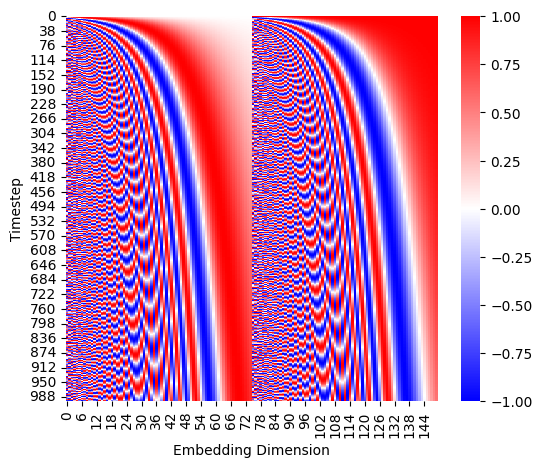

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot some test embeddings
test_time_embeddings = get_timestep_embedding(
    max_timesteps, embedding_dim=150
)

fig, ax = plt.subplots(1,1,figsize=(6,5))
sns.heatmap(test_time_embeddings, cmap='bwr', ax=ax)
ax.set_xlabel('Embedding Dimension')
ax.set_ylabel('Timestep')
plt.show()